##  A. Data Collection and Processing


In [52]:
import requests

def retrieve_vacancies():
    url = "https://api.hh.ru/vacancies"
    params = {
        "text": "IT",
        "area": 113,
        "per_page": 100
    }

    all_vacancies = []
    page = 0

    while True:
        params['page'] = page
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            vacancies = data.get('items', [])

            if not vacancies:
                break

            all_vacancies.extend(vacancies)
            page += 1
        else:
            print(f"Failed to retrieve data: {response.status_code}, {response.text}")
            break

    extracted_data = []
    for vacancy in all_vacancies:
        job_title = vacancy.get('name', 'N/A')
        salary_info = vacancy.get('salary')

        if salary_info:
            salary_from = salary_info.get('from', 'N/A')
            salary_to = salary_info.get('to', 'N/A')
            salary_currency = salary_info.get('currency', 'N/A')
            salary = f"{salary_from} - {salary_to} {salary_currency}" if salary_from != 'N/A' else 'N/A'
        else:
            salary = 'N/A'

        location = vacancy.get('area', {}).get('name', 'N/A')
        employment_type = vacancy.get('employment', {}).get('name', 'N/A')
        posting_date = vacancy.get('published_at', 'N/A')

        extracted_data.append({
            'job_title': job_title,
            'salary': salary,
            'location': location,
            'employment_type': employment_type,
            'posting_date': posting_date
        })

    return extracted_data


## Preprocessing data

In [53]:
import pandas as pd


def preprocess_data(vacancies_data):
    df_vacancies = pd.DataFrame(vacancies_data)

    def extract_salary_range(salary_str):
        if salary_str == 'N/A':
            return None, None
        try:
            salary_parts = salary_str.split(' ')
            salary_min = int(salary_parts[0].replace(' ', '').replace('₽', '').strip()) if salary_parts[0] != 'N/A' else None
            salary_max = int(salary_parts[2].replace(' ', '').replace('₽', '').strip()) if len(salary_parts) > 2 else None
            return salary_min, salary_max
        except:
            return None, None

    df_vacancies[['salary_min', 'salary_max']] = df_vacancies['salary'].apply(lambda x: pd.Series(extract_salary_range(x)))

    return df_vacancies


## Data analysing

In [55]:
def analyze_data(df_vacancies):
    top_positions = df_vacancies['job_title'].value_counts().head(10)

    avg_salary_per_job = df_vacancies.groupby('job_title').agg({'salary_min': 'mean', 'salary_max': 'mean'}).reset_index()

    remote_jobs = df_vacancies[df_vacancies['employment_type'] == 'Удаленная работа']
    remote_trends = remote_jobs.groupby('posting_date').size()

    location_distribution = df_vacancies['location'].value_counts().head(10)

    return top_positions, avg_salary_per_job, remote_trends, location_distribution


## Data visualization

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
def visualize_data(top_positions, avg_salary_per_job, remote_trends, location_distribution):
    # 1) Visualize the most frequently listed IT positions
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_positions.values, y=top_positions.index, palette='viridis')
    plt.title('Top 10 Most Frequent IT Job Titles')
    plt.xlabel('Number of Listings')
    plt.ylabel('Job Title')
    plt.show()

    # 2) Visualize average salary ranges for different IT roles
    plt.figure(figsize=(12, 6))
    avg_salary_per_job = avg_salary_per_job.sort_values('salary_min', ascending=False).head(10)
    sns.barplot(x='salary_min', y='job_title', data=avg_salary_per_job, palette='Blues_d', label='Min Salary')
    sns.barplot(x='salary_max', y='job_title', data=avg_salary_per_job, palette='Reds_d', label='Max Salary')
    plt.title('Average Salary Range for Different IT Roles')
    plt.xlabel('Salary (₽)')
    plt.ylabel('Job Title')
    plt.legend(title='Salary Range')
    plt.show()

    # 3) Visualize trends in remote work over time
    plt.figure(figsize=(10, 6))
    remote_trends = remote_trends.sort_index()
    plt.plot(remote_trends.index, remote_trends.values, marker='o', linestyle='-', color='b')
    plt.title('Trends in Remote Work Over Time')
    plt.xlabel('Posting Date')
    plt.ylabel('Number of Remote Jobs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4) Visualize geographical distribution of IT jobs
    plt.figure(figsize=(10, 6))
    sns.barplot(x=location_distribution.values, y=location_distribution.index, palette='coolwarm')
    plt.title('Top 10 Locations for IT Jobs')
    plt.xlabel('Number of Jobs')
    plt.ylabel('Location')
    plt.show()


Failed to retrieve data: 400, {"description":"you can't look up more than 2000 items in the list","bad_argument":"page, per_page","bad_arguments":[{"name":"page, per_page","description":"you can't look up more than 2000 items in the list"}],"errors":[{"value":"page","type":"bad_argument"},{"value":"per_page","type":"bad_argument"}],"request_id":"17412932063059d4b38f01e3f9433bc1"}


<ipython-input-56-af06ac729a86>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_positions.values, y=top_positions.index, palette='viridis')


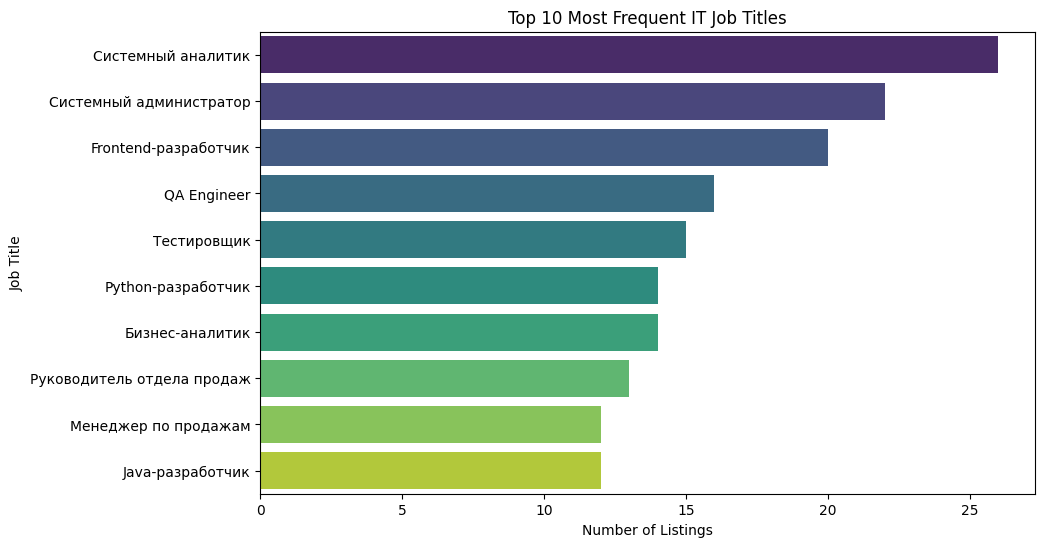

<ipython-input-56-af06ac729a86>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='salary_min', y='job_title', data=avg_salary_per_job, palette='Blues_d', label='Min Salary')
<ipython-input-56-af06ac729a86>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='salary_max', y='job_title', data=avg_salary_per_job, palette='Reds_d', label='Max Salary')


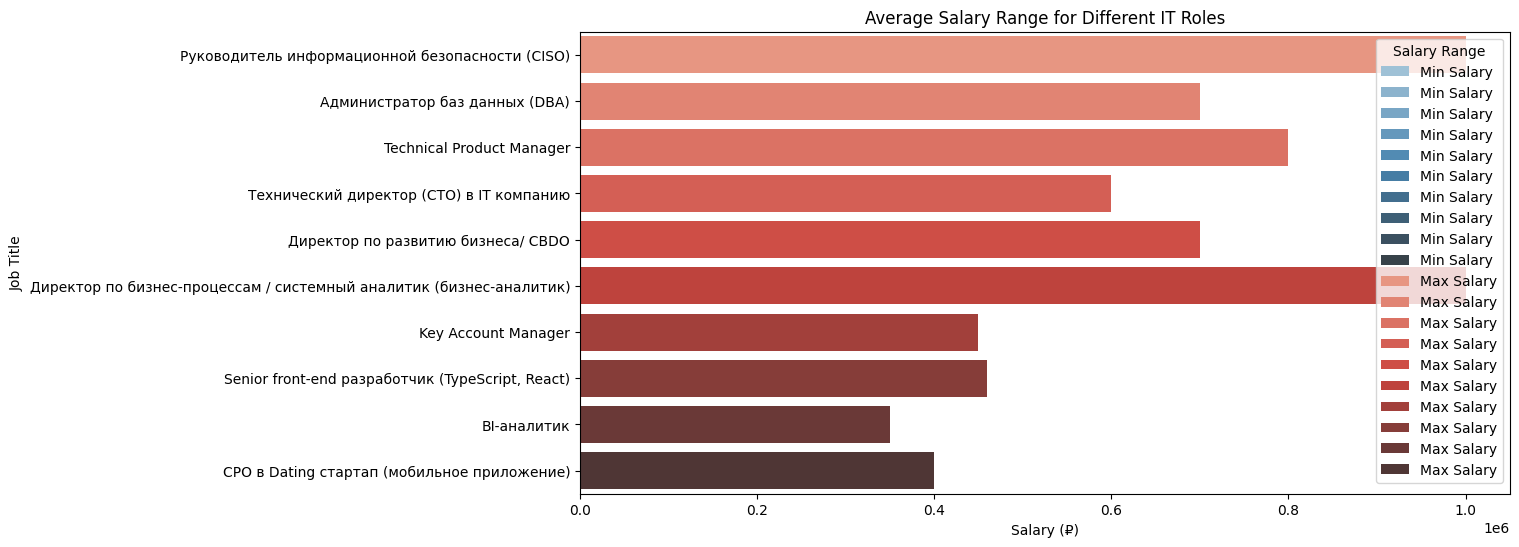

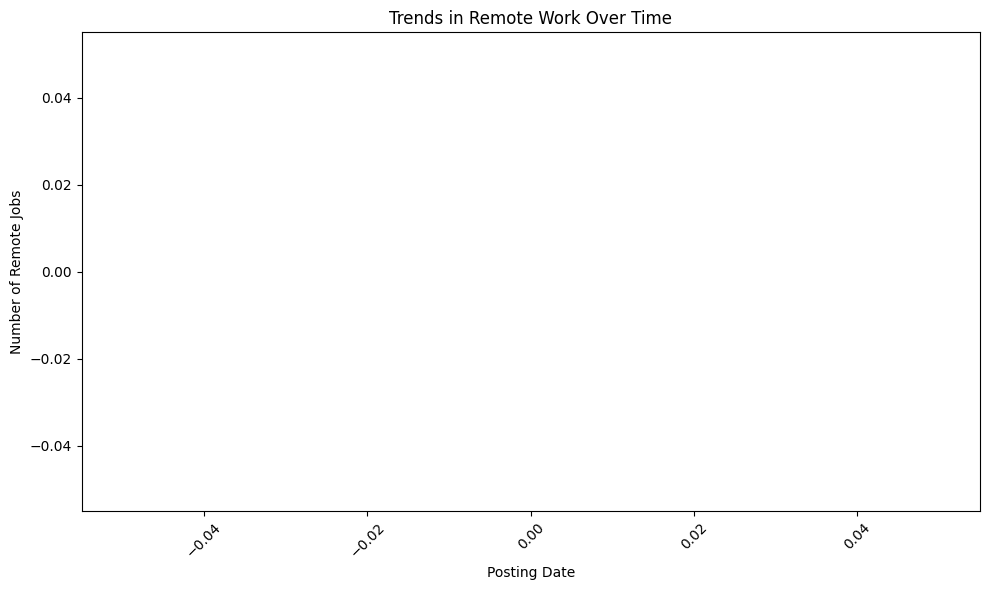

<ipython-input-56-af06ac729a86>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_distribution.values, y=location_distribution.index, palette='coolwarm')


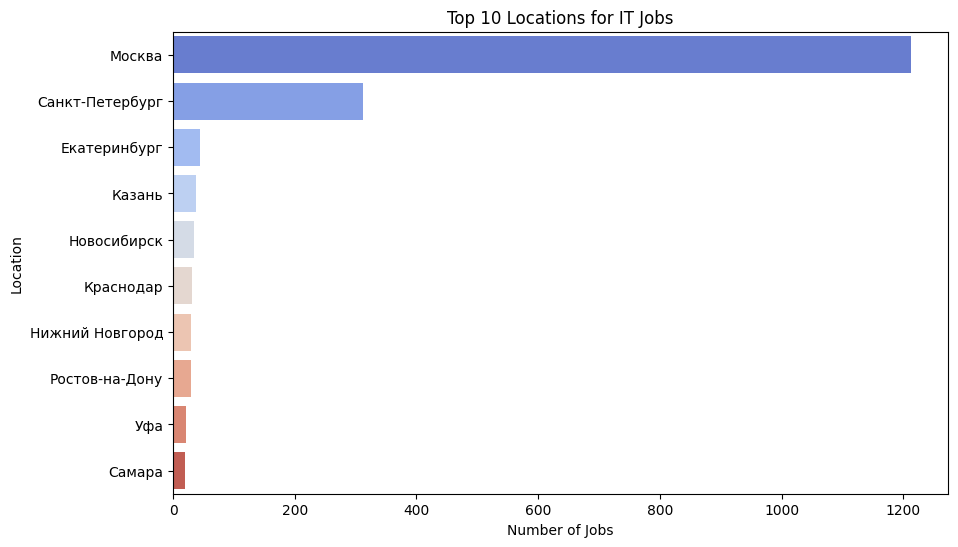

In [57]:
vacancies_data = retrieve_vacancies()

df_vacancies = preprocess_data(vacancies_data)

top_positions, avg_salary_per_job, remote_trends, location_distribution = analyze_data(df_vacancies)

visualize_data(top_positions, avg_salary_per_job, remote_trends, location_distribution)

In [51]:
df_vacancies

,job_title,salary,location,employment_type,posting_date,salary_min,salary_max
0,"Тестировщик с опытом тестирования Битрикс24, C...",N/A,Москва,Полная занятость,2025-02-25T10:21:22+0300,NaN,NaN
1,QA engineer (Pipeliner),N/A,Москва,Полная занятость,2025-03-06T09:48:06+0300,NaN,NaN
2,Technical Product Manager,600000 - 800000 RUR,Москва,Полная занятость,2025-03-06T19:36:32+0300,600000.0,800000.0
3,Тестировщик отдела разработки ПО,N/A,Москва,Полная занятость,2025-03-06T12:30:57+0300,NaN,NaN
4,Директор по закупкам и логистике,300000 - None RUR,Калининград,Полная занятость,2025-03-06T11:01:09+0300,NaN,NaN
...,...,...,...,...,...,...,...
1995,Менеджер проектов,100000 - None RUR,Екатеринбург,Полная занятость,2025-02-17T13:06:45+0300,NaN,NaN
1996,Python разработчик,90000 - None RUR,Красноярск,Полная занятость,2025-02-25T13:49:09+0300,NaN,NaN
1997,"Разработчик Unity, C# Middle",120000 - 160000 RUR,Санкт-Петербург,Полная занятость,2025-03-04T18:36:18+0300,120000.0,160000.0
1998,Руководитель по развитию партнерской сети в IT...,500300 - 5000500 RUR,Москва,Полная занятость,2025-03-06T13:48:30+0300,500300.0,5000500.0
